47
47
   Unnamed: 0        date       cam_id  ...  place  vehicle_count pedestrian_count
0           0  2020-03-27  vWPP0VSa13/  ...    0.0            0.0                5
1           1  2020-03-27  vWPP0VSa13/  ...    0.0            0.0               15
2           2  2020-03-27  vWPP0VSa13/  ...    0.0            0.0                9
3           3  2020-03-28  vWPP0VSa13/  ...    0.0            0.0               10
4           4  2020-03-28  vWPP0VSa13/  ...    0.0            0.0                4

[5 rows x 9 columns]
  date_keys          IDs  pedestrian_count_normalized
0    03-30   oevG6BBrR2/                         0.60
1    03-31   oevG6BBrR2/                         0.60
2    04-01   oevG6BBrR2/                         0.55
3    04-02   oevG6BBrR2/                         0.70
4    04-03   oevG6BBrR2/                         0.60


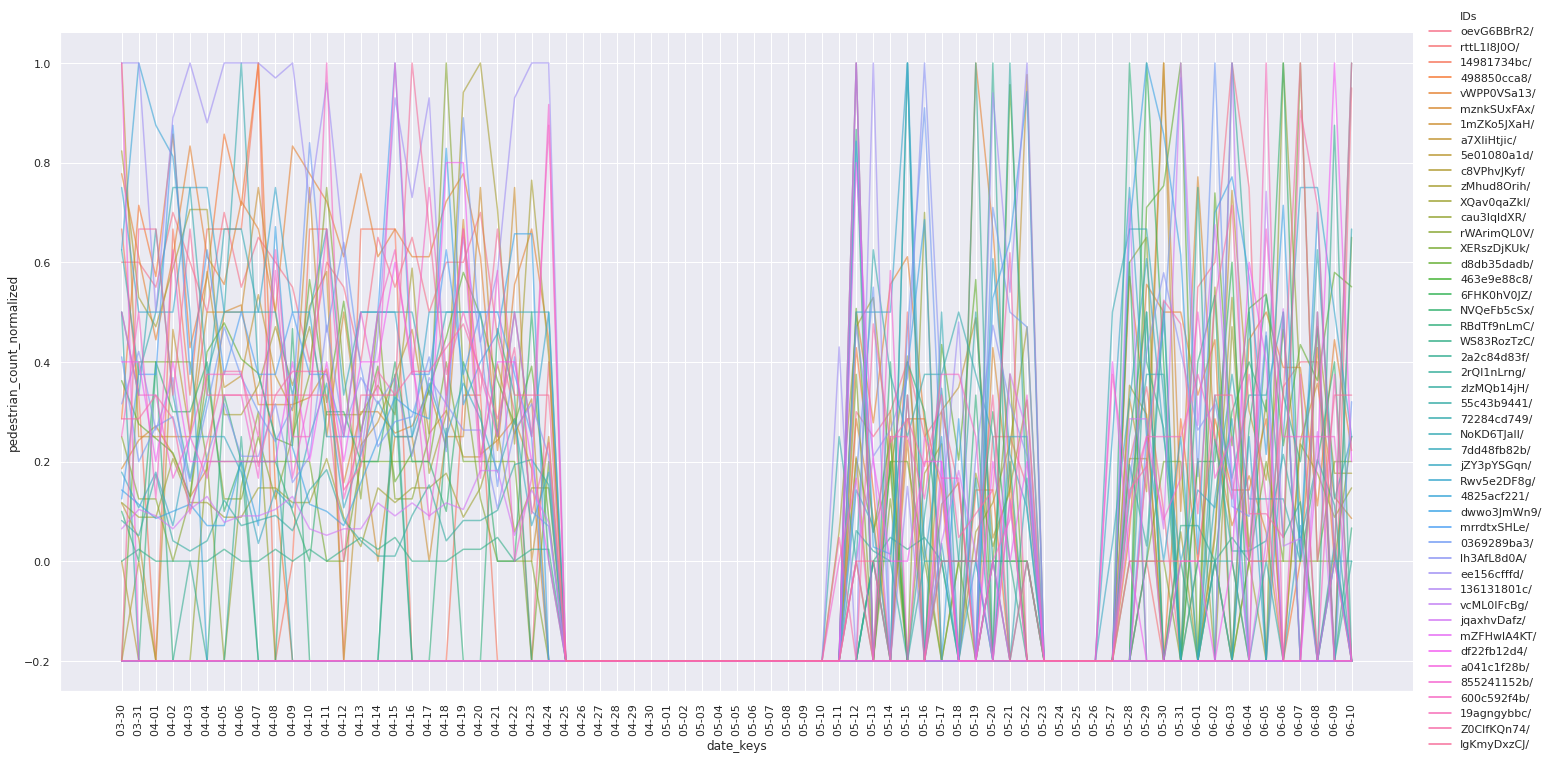

In [ ]:
import pandas as pd 
import numpy as np
from datetime import datetime as dt
from datetime import timedelta as delta
import matplotlib.pyplot as plt
import seaborn as sns

cars = "/content/cars.csv"
people = "/content/ppl.csv"

def get_count(df, mask, mean, std, key):
    cols = {key: np.max}
    data = df[mask]
    df = df.groupby("date").agg(cols).reset_index()
    red = data.groupby("date").agg(cols).reset_index()
    red["date"] = red["date"].apply(lambda x: dt.strptime(x, "%Y-%m-%d"))

    # maybe
    #red[key] = (red[key] - mean)/std
    #red[key] = ((red[key]) - min(red[key]))/(max(red[key])- min(red[key]))
    red[key] = red[key]/max(red[key])
    return red, max(red["date"]), dt.strptime("2020-03-30", "%Y-%m-%d")

def ungroup(df, values, col):
    df_masks = {}
    cols = {col: np.max}
    df2 = df.groupby("date").agg(cols).reset_index()

    mean = np.mean(df2[col])
    std = np.std(df2[col])

    length = None
    date = dt.strptime("2020-03-30", "%Y-%m-%d")
    for key in values:
        #print(key)
        mask = df["cam_id"].apply(lambda x: x == key)
        data, max_date, start = get_count(df, mask, mean, std, key = col)
        data = data.set_index("date")
        if max_date > date:
            date = max_date
        length = sum(mask.apply(lambda x: 1 if x else 0))
        df_masks.update({key: {"mask":mask, "length":length, "data": data, "last_date": max_date, "first_date": start}})
    
    start = dt.strptime("2020-03-30", "%Y-%m-%d")
    td = delta(days = 1)
    dates = [start]
    while start < date:
        start += td
        dates.append(start)
    dates = pd.DataFrame(dates, columns=['date_keys'])

    return df_masks, dates

def construct_new(data, dates, col = "pedestrian_count", limit = None):
    frames = []
    if limit == None:
        for key in data.keys():
            data[key]["data"] = data[key]["data"].reindex(dates["date_keys"])
            data[key]["data"].columns = [key]
            frames.append(data[key]["data"])
    else:
        for i, key in enumerate(data.keys()):
            data[key]["data"] = data[key]["data"].reindex(dates["date_keys"])
            data[key]["data"].columns = [key]
            frames.append(data[key]["data"])
            if i > limit:
                break

    datafin = pd.concat(frames, axis = 1)
    return data , datafin

def load_csv(filen, col):
    data = pd.read_csv(filen)
    data = data.fillna(0)
    keys = set(list(data["cam_id"].values))
    print(len(keys))
    keys, dates = ungroup(data, keys, col = col)
    keys, flattened = construct_new(keys, dates, limit = None)
    print(len(flattened.columns))
    flattened = flattened.fillna(-0.2)
    flattened = flattened.sort_index()
    flattened = flattened.reset_index()
    flattened["date_keys"] = flattened["date_keys"].apply(lambda x: str(x).replace("00:00:00", "").replace("2020-", ""))
    return data, keys, dates, flattened

col = "vehicle_count"
data, keys, dates, colap = load_csv(people, col)
print(data.head())

df2 = pd.melt(colap, 'date_keys', var_name='IDs', value_name=f"{col}_normalized")
print(df2.head())

g = sns.relplot(x="date_keys", y=f"{col}_normalized", hue = "IDs", height=10, aspect=2, data=df2, alpha=0.6, kind='line')
g.set_xticklabels(rotation=90)
#g = sns.lineplot(x="date_keys", y="oevG6BBrR2/", data=df2, alpha=0.5)